In [1]:
from huggingface_hub import login
# login(token=...)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to C:\Users\2mrwm\.cache\huggingface\token
Login successful


In [2]:
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          pipeline, AutoModelForCausalLM, BitsAndBytesConfig, AutoModel)
import pandas as pd
import torch

In [11]:
model_name = "meta-llama/Llama-2-3b-hf"
# hf_token = ...

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.bfloat16,
    load_in_8bit_fp32_cpu_offload=True
)
llama_tokenizer = AutoTokenizer.from_pretrained(model_name)
llama_tokenizer.pad_token = llama_tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map='auto'
)

OSError: meta-llama/Llama-2-3b-hf is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [8]:
text_gen = pipeline(
    'text-generation',
    model=model,
    tokenizer=llama_tokenizer,
    max_new_tokens=20,
)

messages = [
    {"role": "system", "content": "You have to classify a line of text based on main topic. Do so in a one word response."
                                  "You have the following choices for topics: "
                                  "relationships, dairies & daily life, politics, and food & cooking"},
    {"role": "user", "content": "If I wanted to kill my husband,  I'd do it and I wouldn't get caught."},
]
prompt = f"<s>[INST] {messages[0]['content']} [/INST] {messages[1]['content']} </s>"

response = text_gen(prompt)
output = response[0]['generated_text']
print(output)

The model 'LlamaModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM

TypeError: The current model class (LlamaModel) is not compatible with `.generate()`, as it doesn't have a language model head. Please use one of the following classes instead: {'LlamaForCausalLM'}

In [2]:
import pandas as pd
llama3_8b = pd.read_csv('llama_results/results_llama3_70b_2.csv')

In [5]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

def topic_distribution(results_dataset):
    different_topics = results_dataset['result']
    count = Counter(different_topics)
    
    topics = [topic for topic in count]
    height = [n for n in count.values()]
    bar_df = pd.DataFrame()
    bar_df['topic'] = topics
    bar_df['count'] = height
    sns.barplot(data=bar_df, x='count', y='topic', palette='Blues_r')
    
    total_count = np.sum(np.array(height))
    for t in count:
        print(f' The percentage for {t} is: {round(((count[t] / total_count) * 100), 2)}%')
    


C:\Users\2mrwm\AppData\Local\Temp\ipykernel_21224\2591719452.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_df, x='count', y='topic', palette='Blues_r')


 The percentage for Self-Improvement is: 2.15%
 The percentage for Food and Dining is: 12.83%
 The percentage for Meme is: 18.61%
 The percentage for Relationships is: 6.42%
 The percentage for Art and Culture is: 7.08%
 The percentage for Personal Vlogs & Daily Life  is: 24.76%
 The percentage for Fashion and Beauty is: 9.85%
 The percentage for Health and Fitness is: 8.03%
 The percentage for Politics and Social Issues is: 7.43%
 The percentage for Gender is: 1.11%
 The percentage for Crime is: 1.51%
 The percentage for Other is: 0.23%
None


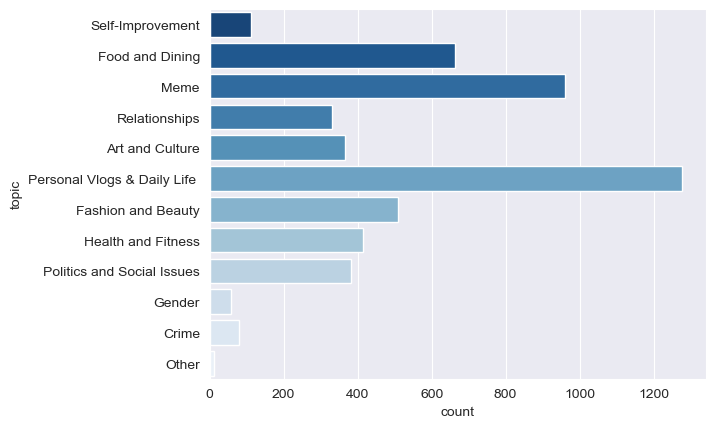

In [6]:
llama3_70b = pd.read_csv('llama_results/results_llama3_70b_2.csv')
llama3_70b_topic_distribution = topic_distribution(llama3_70b)
print(llama3_70b_topic_distribution)

In [38]:
from sklearn.metrics import accuracy_score, classification_report
test_set_1 = pd.read_csv('llama_results/results_testset.csv')
test_set_2 = pd.read_csv('test_sets/labelled.csv', delimiter=';')

results_set = test_set_1.copy()
conv_dict = {'Crime': 'politics', 'Gender': 'politics', 'Food and Dining': 'food', 
             'Personal Vlogs & Daily Life ': 'vlog', 'Health and Fitness': 'health', 
             'Meme': 'meme', 'Politics and Social Issues': 'politics', 'Art and Culture': 'art',
             'Self-Improvement': 'self', 'Fashion and Beauty': 'beauty', 'Relationships': 'relationships', 'Other': 'misc'}


group_meme = True
if group_meme:
    conv_dict2 = {'misc': 'meme'}
    conv_dict['Other'] = 'meme'
    for manual_topic, new_manual_topic in conv_dict2.items():
        test_set_2['manual_topic'] = test_set_2['manual_topic'].replace(manual_topic, new_manual_topic)

for llama_topic, manual_topic in conv_dict.items():
    results_set['result'] = results_set['result'].replace(llama_topic, manual_topic)


performance = classification_report(y_true=test_set_2['manual_topic'], y_pred=results_set['result'])

In [39]:
print(performance)

               precision    recall  f1-score   support

          art       0.41      0.53      0.46        17
       beauty       0.80      0.77      0.78        26
         food       0.70      0.93      0.80        28
       health       0.28      0.71      0.40         7
         meme       0.50      0.40      0.45        72
     politics       0.50      0.82      0.62        22
relationships       0.83      0.28      0.42        54
         self       0.60      0.55      0.57        11
         vlog       0.52      0.63      0.57        62

     accuracy                           0.56       299
    macro avg       0.57      0.62      0.56       299
 weighted avg       0.60      0.56      0.55       299
